In [ ]:
import hashlib, os, threading
import numpy as np 
import math
import scipy.ndimage
from skimage import measure
from skimage import morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import axes3d
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, plot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
import glob
import random
from dicompylercore import  dvh, dvhcalc
from dicompylercore.dicomparser import DicomParser 
from six import PY2, iterkeys, string_types, BytesIO
from shapely.geometry import Polygon
from scipy import linalg
try:
    from pydicom.dicomio import read_file
    from pydicom.dataset import Dataset
except ImportError:
    from dicom import read_file
    from dicom.dataset import Dataset

data-preprocess

In [570]:

import hashlib, os, threading
import numpy as np 
import math
import scipy.ndimage
from skimage import measure
from skimage import morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import axes3d
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, plot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
import glob
import random
from dicompylercore import  dvh, dvhcalc
from dicompylercore.dicomparser import DicomParser 
from six import PY2, iterkeys, string_types, BytesIO
from shapely.geometry import Polygon
from scipy import linalg
try:
    from pydicom.dicomio import read_file
    from pydicom.dataset import Dataset
except ImportError:
    from dicom import read_file
    from dicom.dataset import Dataset
    



class dicommethodcore:
    def searchpath(path):
        if os.path.isdir(path):
            files = []
            for root, dirs, filenames in os.walk(path):
                files += map(lambda f:os.path.join(root, f), filenames)
        else:
            files =[path]
        return files
    def getdicomdatainfo(files):
        for n in range(len(files)):
            # terminate the thread if the value has changed
            # during the loop duration
            if (n == 0):
                #store information rtss structure image  
                #store all read data
                patients = {}
                ptdata={}
                h_record={}
                #creat h if not exist for more different 
                #patient['rxdose'] = RxDose
                # plan['rxdose']=max dose
                #  dosemax=int(isodose.pixel_array.max() * self.DoseGridScaling * 10000 / isodose)
                #    data['dosemax'] = float(self.ds.pixel_array.max())
                #create data from first

            if (os.path.isfile(files[n])):
                try:
                    dp = DicomParser(files[n])
                except (AttributeError, EOFError, IOError, KeyError):
                    pass
                    print("%s is not a valid DICOM file.", files[n])
                else:
                    #creat h if not exist for more different 
                    patientGe = dp.GetDemographics()
                    h1=hashlib.sha1((dp.ds.PatientID).encode('utf-8')).hexdigest()
                    #h2=hashlib.sha1((dp.ds.StudyDate).encode('utf-8')).hexdigest()
                    h2=dp.ds.StudyDate
                    #h3=hashlib.sha1((dp.ds.StudyInstanceUID).encode('utf-8')).hexdigest()
                    h = h1+h2
                    if not h in patients:
                        h_record[h] =[]
                        patients[h] = {}
                        ptdata[h]={}
                        patients[h]['patientinfo']={}
                        patients[h]['patientinfo']['demographics'] = patientGe
                        if not 'studies' in patients[h]:
                            patients[h]['patientinfo']['studies'] = {}
                            patients[h]['patientinfo']['series'] = {}
                        #wx.CallAfter(foundFunc, patient)
                    # Create each Study but don't create one for RT Dose
                    # since some vendors use incorrect StudyInstanceUIDs
                    if not (dp.GetSOPClassUID() == 'rtdose'):
                        stinfo = dp.GetStudyInfo()
                        if not stinfo['id'] in patients[h]['patientinfo']['studies']:
                            patients[h]['patientinfo']['studies'][stinfo['id']] = stinfo
                        # Create each Series of images
                    if (('ImageOrientationPatient' in dp.ds) and not (dp.GetSOPClassUID() == 'rtdose')): 
                        seinfo = dp.GetSeriesInfo()
                        seinfo['numimages'] = 0
                        seinfo['modality'] = dp.ds.SOPClassUID.name
                        if not seinfo['id'] in patients[h]['patientinfo']['series']:
                            patients[h]['patientinfo']['series'][seinfo['id']] = seinfo
                            h_record[h] += [seinfo['id']]
                        if not 'images' in patients[h]:
                            patients[h]['images'] = {}
                            ptdata[h]['images']={}
                        image = {}
                        image['id'] = dp.GetSOPInstanceUID()
                        image['filename'] = files[n]
                        image['series'] = seinfo['id']
                        image['referenceframe'] = dp.GetFrameOfReferenceUID()
                        patients[h]['patientinfo']['series'][seinfo['id']]['numimages'] =                             patients[h]['patientinfo']['series'][seinfo['id']]['numimages'] + 1
                        patients[h]['images'][image['id']] = image
                        if not seinfo['id'] in ptdata[h]['images']:
                            ptdata[h]['images'][seinfo['id']]=[]                            
                        ptdata[h]['images'][seinfo['id']].append(dp.ds)
                        # Create each RT Structure Set
                    elif dp.ds.Modality in ['RTSTRUCT']:
                    #dp.ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.481.3')
                        if not 'structures' in patients[h]:
                            patients[h]['structures'] = {}
                            ptdata[h]['structures'] = {}
                        structure = dp.GetStructureInfo()
                        structure['id'] = dp.GetSOPInstanceUID()
                        structure['filename'] = files[n]
                        ser=dp.GetReferencedSeries()
                        structure['series'] = ser
                        structure['referenceframe'] = dp.GetFrameOfReferenceUID()
                        patients[h]['structures'][structure['id']] = structure
                        if not ser in ptdata[h]['structures']:
                            ptdata[h]['structures'][ser]=[]
                        ptdata[h]['structures'][ser].append(dp.ds)
                            # Create each RT Plan
                    elif dp.ds.Modality in ['RTPLAN']:
                    #dp.ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.481.5')
                        if not 'plans' in patients[h]:
                            patients[h]['plans'] = {}
                            ptdata[h]['plans']=[] 
                        plan = dp.GetPlan()
                        plan['id'] = dp.GetSOPInstanceUID()
                        plan['filename'] = files[n]
                        plan['series'] = dp.ds.SeriesInstanceUID
                        plan['referenceframe'] = dp.GetFrameOfReferenceUID()
                        plan['beams'] = dp.GetReferencedBeamsInFraction()
                        plan['rtss'] = dp.GetReferencedStructureSet()
                        patients[h]['plans'][plan['id']] = plan
                        ptdata[h]['plans'].append(dp.ds)
                            # Create each RT Dose
                    elif dp.ds.Modality in ['RTDOSE']:
                    #dp.ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.481.2')
                        if not 'doses' in patients[h]:
                            patients[h]['doses'] = {}
                            ptdata[h]['doses']=[]
                        dose = {}
                        dose['id'] = dp.GetSOPInstanceUID()
                        dose['filename'] = files[n]
                        dose['referenceframe'] = dp.GetFrameOfReferenceUID()
                        dose['hasdvh'] = dp.HasDVHs()
                        dose['hasgrid'] = "PixelData" in dp.ds
                        dose['summationtype'] = dp.ds.DoseSummationType
                        dose['beam'] = dp.GetReferencedBeamNumber()
                        dose['rtss'] = dp.GetReferencedStructureSet()
                        rtplan=dp.GetReferencedRTPlan()
                        dose['rtplan'] = rtplan
                        patients[h]['doses'][dose['id']] = dose
                        ptdata[h]['doses'].append(dp.ds)
                       # patients[h]['images'][dose['id']].append(dp.ds)


                    # Otherwise it is a currently unsupported file
                    else:
                        print("%s is a %s file and is not " +  "currently supported.",
                              files[n], dp.ds.SOPClassUID.name)
        return patients, h_record,ptdata
        
    def resortimage(patients,s,si):
        if 'images' in patients[s]:
            sortedimages = []
            unsortednums = []
            sortednums = []
            images = patients[s]['images'][si]
            sort = 'IPP'
                # Determine if all images in the series are parallel
                # by testing for differences in ImageOrientationPatient
            parallel = True
            for i, item in enumerate(images):
                if (i > 0):
                    iop0 = np.array(item.ImageOrientationPatient)
                    iop1 = np.array(images[i-1].ImageOrientationPatient)
                    if (np.any(np.array(np.round(iop0 - iop1),
                    dtype=np.int32))):
                        parallel = False
                        break
                        # Also test ImagePositionPatient, as some series
                        # use the same patient position for every slice
                    ipp0 = np.array(item.ImagePositionPatient)
                    ipp1 = np.array(images[i-1].ImagePositionPatient)
                    if not (np.any(np.array(np.round(ipp0 - ipp1),
                    dtype=np.int32))):
                        parallel = False
                        break
            # If the images are parallel, sort by ImagePositionPatient
            if parallel:
                sort = 'IPP'
            else:
                # Otherwise sort by Instance Number
                if not (images[0].InstanceNumber == images[1].InstanceNumber):
                    sort = 'InstanceNumber'
                # Otherwise sort by Acquisition Number
                elif not (images[0].AcquisitionNumber == images[1].AcquisitionNumber):
                    sort = 'AcquisitionNumber'

                # Add the sort descriptor to a list to be sorted
            for i, image in enumerate(images):
                if (sort == 'IPP'):
                    unsortednums.append(image.ImagePositionPatient[2])
                else:
                    unsortednums.append(image.data_element(sort).value)

                    # Sort image numbers in descending order for head first patients
            if ('hf' in image.PatientPosition.lower()) and (sort == 'IPP'):
                sortednums = sorted(unsortednums, reverse=True)
                # Otherwise sort image numbers in ascending order
            else:
                sortednums = sorted(unsortednums)

                # Add the images to the array based on the sorted order
            for k, slice in enumerate(sortednums):
                for i, image in enumerate(images):
                    if (sort == 'IPP'):
                        if (slice == image.ImagePositionPatient[2]):
                            sortedimages.append(image)
                    elif (slice == image.data_element(sort).value):
                        sortedimages.append(image)

                # Save the images back to the patient dictionary
            
            return sortedimages
    def structure_method(structuredata):
        structures = {}
        for i in range(0,len(structuredata)):
            structures[i]={}
            strd=structuredata[i]        
            """Returns a dictionary of structures (ROIs)."""
            # Determine whether this is RT Structure Set file
            if not (strd.Modality == 'RTSTRUCT'):
                return structures

            # Locate the name and number of each ROI
            if 'StructureSetROISequence' in strd:
                for item in strd.StructureSetROISequence:
                    data = {}
                    number = int(item.ROINumber)
                    data['id'] = number
                    data['name'] = item.ROIName
                    print("Found ROI #%s: %s", str(number), data['name'])
                    structures[i][number] = data

            # Determine the type of each structure (PTV, organ, external, etc)
            if 'RTROIObservationsSequence' in strd:
                for item in strd.RTROIObservationsSequence:
                    number = item.ReferencedROINumber
                    if number in structures:
                        structures[i][number]['type'] = item.RTROIInterpretedType

            # The coordinate data of each ROI is stored within ROIContourSequence
            if 'ROIContourSequence' in strd:
                for roi in strd.ROIContourSequence:
                    number = roi.ReferencedROINumber

                    # Generate a random color for the current ROI
                    structures[i][number]['color'] = np.array((
                        random.randint(0, 255),
                        random.randint(0, 255),
                        random.randint(0, 255)), dtype=int)
                    # Get the RGB color triplet for the current ROI if it exists
                    if 'ROIDisplayColor' in roi:
                        # Make sure the color is not none
                        if not (roi.ROIDisplayColor is None):
                            color = roi.ROIDisplayColor
                        # Otherwise decode values separated by forward slashes
                        else:
                            value = roi[0x3006, 0x002a].repval
                            color = value.strip("'").split("/")
                        # Try to convert the detected value to a color triplet
                        try:
                            structures[i][number]['color'] =np.array(color, dtype=int)
                        # Otherwise fail and fallback on the random color
                        except:
                            print(
                                "Unable to decode display color for ROI #%s",
                                str(number))

                    # Determine whether the ROI has any contours present
                    if 'ContourSequence' in roi:
                        structures[i][number]['empty'] = False
                    else:
                        structures[i][number]['empty'] = True

            return structures
    def GetStructureCoordinates(self, roi_number):
        """Get the list of coordinates for each plane of the structure."""
        datarange=[]

        planes = {}
        # The coordinate data of each ROI is stored within ROIContourSequence
        if 'ROIContourSequence' in self:
            for roi in self.ROIContourSequence:
                if (roi.ReferencedROINumber == int(roi_number)):
                    if 'ContourSequence' in roi:
                        # Locate the contour sequence for each referenced ROI
                        for c in roi.ContourSequence:
                            # For each plane, initialize a new plane dict
                            plane = {}
                            n=3

                            # Determine all the plane properties
                            plane['type'] = c.ContourGeometricType
                            plane['num_points'] = int(c.NumberOfContourPoints)
                            plane['data'] = [c.ContourData[i:i+n] for i in range(0, len(c.ContourData), n)]
                            '''plane['data'] =                                     self.GetContourPoints(c.ContourData)'''
                            """Parses an array of xyz points & returns a array of point dicts."""
                            '''def GetContourPoints(self, array):
                             n = 3
                             return [array[i:i+n] for i in range(0, len(array), n)]'''
                            datara=list(zip(*plane['data']))
                            if not datarange:
                                datarange=([min(datara[0]),min(datara[1]),max(datara[0]),max(datara[1])])
                            else:
                                if ((datarange[0]>(min(datara[0])))):
                                    datarange[0]=min(datara[0])
                                if ((datarange[2]<(max(datara[0])))):
                                    datarange[2]=max(datara[0])
                                if ((datarange[1]>(min(datara[1])))):
                                    datarange[1]=min(datara[1])
                                if ((datarange[-1]<(max(datara[1])))):
                                    datarange[-1]=max(datara[1])

                            # Each plane which coincides with an image slice
                            # will have a unique ID
                            if 'ContourImageSequence' in c:
                                # Add each plane to the planes dict
                                # of the current ROI
                                z = str(round(plane['data'][0][2], 2)) + '0'
                                if z not in planes:
                                    planes[z] = []
                                planes[z].append(plane)

        datarange=([(datarange[0],datarange[1]),(datarange[2],datarange[3])])
        return planes,datarange
    def CalculatePlaneThickness(self, planesDict):
        """Calculates the plane thickness for each structure."""
        planes = []
        # Iterate over each plane in the structure
        for z in iterkeys(planesDict):
            planes.append(float(z))
        planes.sort()

        # Determine the thickness
        thickness = 10000
        for n in range(0, len(planes)):
            if (n > 0):
                newThickness = planes[n] - planes[n-1]
                if (newThickness < thickness):
                    thickness = newThickness

            # If the thickness was not detected, set it to 0
        if (thickness == 10000):
            thickness = 0

        return thickness
    
    def catchstructure(image,structure):
        #if (structure['name']=='*Skull'):
            #return
        print(structure['name'])
        position=image["imagelocation"]
        pixel = image['pixel']
        if not "zarray" in structure:
            structure['zarray'] = np.array(list(structure['planes'].keys()), dtype=np.float32)
            structure['zkeys'] = structure['planes'].keys()
        # Return if there are no z positions in the structure data
        if not len(structure['zarray']):
            return
        #這邊要去想方法一次抓出全部的座標
        
        structurerange=dicommethodcore.GetContourPixelData(image,structure['datarange'])
        
        structurepointlist={}
        structurepixel={}
        structurepixelshpae=[]
        #listrange={}
        for z in range(0,len(structure['zkeys'])) :
            zmin = np.amin(np.abs(structure['zarray'][z] - list(map(float, position))))
            index = np.argmin(np.abs(structure['zarray'][z] - list(map(float, position))))
            #zmin = np.amin(np.abs(structure['zarray'] - float(position)))
            #index = np.argmin(np.abs(structure['zarray'] - float(position)))
            
            # Draw the structure only if the structure has contours
            # on the closest plane, within a threshold
            #if (zmin < 0.5):
            if (zmin < 1.5):
                # Set the color of the contour
                '''
                color = wx.Colour(structure['color'][0], structure['color'][1],
                    structure['color'][2], int(self.structure_fill_opacity*255/100))
                # Set fill (brush) color, transparent for external contour
                if (('type' in structure) and (structure['type'].lower() == 'external')):
                    gc.SetBrush(wx.Brush(color, style=wx.TRANSPARENT))
                else:
                    gc.SetBrush(wx.Brush(color))
                gc.SetPen(wx.Pen(tuple(structure['color']),
                    style=self.GetLineDrawingStyle(self.structure_line_style)))
                # Create the path for the contour
                path = gc.CreatePath()
                '''
                for contour in structure['planes'][list(structure['zkeys'])[z]]:
                    if (contour['type'] == u"CLOSED_PLANAR"):
                        
                        # Convert the structure data to pixel data
                        pixeldata = dicommethodcore.GetContourPixelData(
                            image, contour['data'])
                        
                        
                        # fill all corrindonate

                        # Move the origin to the last point of the contour
                        
                        pixeldata=dicommethodcore.connectcircle(pixeldata)
                        #point = pixeldata[-1]
                        #catch all pixelpoint
                        pixelpoint= dicommethodcore.fillcorrinate(pixeldata)
                        #shpae pixel
                        #structurepixeldata=np.array([[-1 for y in range(len(sorted(list(set(list(zip(*pixelpoint))[1])))))] for x in range(len(sorted(list(set(list(zip(*pixelpoint))[0])))))],dtype=np.int16)
                        #[number[row[col]]] so if see x should see col as see y should row
                        #plot x  corrindiate see col y corrindiate see row
                        structurepixeldata=np.array([[-1 for x in range(structurerange[0][0],(structurerange[1][0]+1))]for y in range(structurerange[0][1],(structurerange[1][1]+1))],dtype=np.int16)
                        
                        #structurepixeldata=np.array([[-1 for x in range(len(sorted(list(set(list(zip(*pixelpoint))[0])))))]for y in range(len(sorted(list(set(list(zip(*pixelpoint))[1])))))],dtype=np.int16)
                        ida=0
                        listx=list(x-structurerange[0][0] for x in (list(zip(*pixelpoint))[0]))
                        listy=list(y-structurerange[0][1] for y in (list(zip(*pixelpoint))[1]))
                        '''
                        listran=[min(list(zip(*pixelpoint))[0]),max(list(zip(*pixelpoint))[0]),min(list(zip(*pixelpoint))[1]),max(list(zip(*pixelpoint))[1])]
                        listx=list(x-min(list(zip(*pixelpoint))[0]) for x in (list(zip(*pixelpoint))[0]))
                        listy=list(y-min(list(zip(*pixelpoint))[1]) for y in (list(zip(*pixelpoint))[1]))
                        '''
                        for i in range(0,len(listx)):
                            #structurepixeldata[listx[ida]][listy[ida]]=pixel[index][pixelpoint[ida][1]][pixelpoint[ida][0]]
                            structurepixeldata[listy[ida]][listx[ida]]=pixel[index][pixelpoint[ida][1]][pixelpoint[ida][0]]
                            ida=ida+1
                #listrange[(structure['zarray'][z])]=listran
                structurepixelshpae.append(structurepixeldata)
                #'''                
                structurepointlist[(structure['zarray'][z])] = pixelpoint
                structurepixel[(structure['zarray'][z])]=pixel[index][(list(zip(*pixelpoint))[0]),(list(zip(*pixelpoint))[1])]
                #'''    
            #抓出座標，接這去抓rgb
        '''
        if (len(structure['zarray'])>1):
            if (structure['zarray'][0]>structure['zarray'][-1]):
                structurepixelshpae.reverse()
        '''
        structurepixelshpae=np.array(structurepixelshpae,dtype=np.int16)        
        return structurepointlist, structurepixel,structurepixelshpae,structurerange
        #return structurepointlist

    def GetContourPixelData(image, contour):
        """Convert structure data into pixel data using the patient to pixel LUT."""

        pixeldata = []
        pixlut=image['pixellut']
        # Determine whether the patient is prone or supine
        if 'p' in image['patientposition'].lower():
            prone = True
        else:
            prone = False
        # Determine whether the patient is feet first or head first
        if 'ff' in image['patientposition'].lower():
            feetfirst = True
        else:
            feetfirst = False
        # For each point in the structure data
        # look up the value in the LUT and find the corresponding pixel pair
        for p, point in enumerate(contour):
            for xv, xval in enumerate(pixlut[0]):
                if (xval > point[0] and not prone and not feetfirst):
                    break
                elif (xval < point[0]):
                    if feetfirst or prone:
                        break
            for yv, yval in enumerate(pixlut[1]):
                if (yval > point[1] and not prone):
                    break
                elif (yval < point[1] and prone):
                    break
            pixeldata.append((xv, yv))

        return pixeldata
    #抓出全部座標
    def connectcircle(circledata):
        """
        input:
        params circledata: give close data
        output:
        circle:conncet  close circle
        
        """
        if (circledata[0])!=(circledata[-1]):
            print('data not close')
            return
        dataind=0
        circle=[]
        while (dataind < (len(circledata)-1)):
            while (dataind< (len(circledata)-1)):
                datafirst=circledata[dataind]
                dataind=dataind+1
                dataend=circledata[dataind]
                if (((datafirst[0])==(dataend[0]))):
                    circle.append(datafirst)
                else:            
                    break


            circletemp=[]
            if datafirst[0]>dataend[0]:
                startx= dataend[0]
                endx=datafirst[0]
                starty=dataend[1]
                endy=datafirst[1]
                fismen=1
            elif(datafirst[0]<dataend[0]):
                startx= datafirst[0]
                endx=dataend[0]
                starty=datafirst[1]
                endy=dataend[1]
                fismen=0

            #yid=-1
            for x in range(startx, (endx+1)):
                y=((x-startx)*(endy-starty)/(endx-startx))+starty
                if (int(y)!=y):
                    #取上，取下
                    #yid=yid+1
                    circletemp.append((x,int(y)))
                    #circletemp.insert(yid,(int(x),int(y)))   
                else:
                    circletemp.append((x,int(y)))
                    #yid=yid+1
                    #circletemp.insert(yid,(int(x),y)) 

                if (x== startx):
                    #yl=1
                    pass

                else:
                    #if ((circletemp[-1][1])>(circletemp[(yid-yl)][1])):
                    if ((circletemp[-1][1])>(circletemp[(-2)][1])):
                        #slope>0
                        circletempmax=circletemp[-1][1]+1
                        #circletempmin=circle[(yid-yl)][1]+1
                        circletempmin=circletemp[(-2)][1]+1
                    #elif((circletemp[-1][1])<(circletemp[(yid-yl)][1])):
                    elif((circletemp[-1][1])<(circletemp[(-2)][1])):
                        #slope<0
                        #circletempmax=circle[(yid-yl)][1]
                        circletempmax=circletemp[(-2)][1]
                        circletempmin=circletemp[-1][1]
                    else:
                        circletempmax=-1
                        circletempmin=0              
                    yid=0
                    #yl=1 
                    for temp in range(circletempmin,circletempmax):
                        #y fromsmall to big 
                        #circletemp.append(((x-1),(temp)))
                        circletemp.insert((yid-1),((x-1),(temp)))
                        #yl=yl+1
                        yid=yid+1
                        #insert O (n) append O(1) extend O(k)

            #if ((dataind!=0)):
            if (circletemp[0] in circle):
                #remove first,to avoid repat last 
                del circletemp[0]
            if (fismen):
                circle.extend(circletemp[-1::-1])
            else:
                circle.extend(circletemp)
        return circle

    def fillcorrinate(pixeldata):
        #xpixlut=pixlut[0]
        #ypixlut=pixlut[1]
        #sortx=sorted(pixeldata, key=lambda x:x[0])
        sortx=sorted(list(set(pixeldata)),key=lambda x:(x[0],x[1]))
        #remove same point and sort b x and y 
        xfirstindex=(min(sortx))[0]
        xlastindex=(max(sortx))[0]
        sortlist=list(zip(*sortx))
        #xfirstindex = np.argmin(np.abs((sortx[0][0])-list(map(float, xpixlut))))
        #xlastindex=np.argmin(np.abs((sortx[-1][0])-list(map(float, xpixlut))))
        findsortdata=[]
        for i in range(xfirstindex,(xlastindex+1)):
            global forwardindfirstx_y,backwardindlastx_y,backwardindfirstx_y,backwardindlastx_y
            #用組數去比對
            if (i in sortlist[0]):
                #while x  in list
                firstx = sortlist[0].index(i)         
                lastx=len(sortx)-(((sortlist[0])))[-1::-1].index(i)-1            
                '''
                firstx=(((list(zip(*sortx)))[0])).index(xpixlut[i])
                firstx_y=np.argmin(np.abs((sortx[firstx][1])-list(map(float, ypixlut))))
                lastx=len(sortx)-(((list(zip(*sortx)))[0]))[-1::-1].index(xpixlut[i])-1
                lastx_y=np.argmin(np.abs((sortx[lastx][1])-list(map(float, ypixlut))))
                '''
                if ((lastx-firstx)):
                    #only in 
                    firstx_y=sortx[firstx][1]
                    lastx_y=sortx[lastx][1]
                    originalsortdata_y=(sortlist[1][firstx:(lastx+1)])
                    for j in range(firstx_y,lastx_y):
                        if j not in originalsortdata_y:
                            findsortdata += [(i,j)]
                else:
                    #while x have same 
                    if ((i  == xfirstindex)):
                        pass
                    elif(i  == (xlastindex)):
                        pass
                    else:
                        forwardind=i+1
                        backwardind=i-1
                        while (forwardind<(xlastindex+1)):
                            if (forwardind in sortlist[0]):
                                forwardindfirstx=sortlist[0].index(forwardind)
                                forwardindlastx=len(sortx)-(((sortlist[0])))[-1::-1].index(forwardind)-1
                                if((forwardindlastx-forwardindfirstx) or (forwardind==(xlastindex))):
                                    forwardindfirstx_y=sortx[forwardindfirstx][1]
                                    forwardindlastx_y=sortx[forwardindlastx][1]
                                    break
                                else:
                                    forwardind=forwardind+1                    
                            else:
                                forwardind=forwardind+1    
                        while (backwardind>(xfirstindex-1)):
                            if (backwardind in sortlist[0]):
                                backwardindfirstx=sortlist[0].index(backwardind)
                                backwardindlastx=len(sortx)-(((sortlist[0])))[-1::-1].index(backwardind)-1
                                if((backwardindlastx-backwardindfirstx) or (backwardind==xfirstindex)):
                                    backwardindfirstx_y=sortx[backwardindfirstx][1]
                                    backwardindlastx_y=sortx[backwardindlastx][1]
                                    break
                                else:
                                    backwardind=backwardind-1
                            else:
                                backwardind=backwardind-1
                        middle_y=sortx[lastx][1]  
                        firstx_y=((forwardindfirstx_y*(i-backwardind))+(backwardindfirstx_y*(forwardind-i)))/(forwardind-backwardind)
                        lastx_y=((forwardindlastx_y*(i-backwardind))+(backwardindlastx_y*(forwardind-i)))/(forwardind-backwardind)
                        if ((middle_y-firstx_y)>(lastx_y-middle_y)):
                            lastx_y=middle_y
                            firstx_y=round(firstx_y)
                        elif ((middle_y-firstx_y)<(lastx_y-middle_y)):
                            firstx_y=middle_y
                            lastx_y=round(lastx_y)

                        if (lastx_y==firstx_y):
                            findsortdata += [(i,firstx_y)]
                        else:
                            for j in range(int(firstx_y),int(lastx_y+1)):
                                findsortdata += [(i,j)]
                        #先找鄰近的位置求內差
            else:
                #while x not in list 
                #first and last must in sortlist
                forwardind=i+1
                backwardind=i-1
                while (forwardind<(xlastindex+1)):
                    if (forwardind in sortlist[0]):
                        forwardindfirstx=sortlist[0].index(forwardind)
                        forwardindlastx=len(sortx)-(((sortlist[0])))[-1::-1].index(forwardind)-1
                        if((forwardindlastx-forwardindfirstx) or (forwardind==(xlastindex))):
                            forwardindfirstx_y=sortx[forwardindfirstx][1]
                            forwardindlastx_y=sortx[forwardindlastx][1]
                            break
                        else:
                            forwardind=forwardind+1                    
                    else:
                        forwardind=forwardind+1       
                while (backwardind>(xfirstindex-1)):

                    if (backwardind in sortlist[0]):
                        backwardindfirstx=sortlist[0].index(backwardind)
                        backwardindlastx=len(sortx)-(((sortlist[0])))[-1::-1].index(backwardind)-1
                        if((backwardindlastx-backwardindfirstx) or (backwardind==xfirstindex)):
                            backwardindfirstx_y=sortx[backwardindfirstx][1]
                            backwardindlastx_y=sortx[backwardindlastx][1]
                            break
                        else:
                            backwardind=backwardind-1
                    else:
                        backwardind=backwardind-1

                firstx_y=((forwardindfirstx_y*(i-backwardind))+(backwardindfirstx_y*(forwardind-i)))/(forwardind-backwardind)
                lastx_y=((forwardindlastx_y*(i-backwardind))+(backwardindlastx_y*(forwardind-i)))/(forwardind-backwardind)
                if (lastx_y==firstx_y):
                    findsortdata += [(i,firstx_y)]
                else:
                    for j in range(int(firstx_y),(int(lastx_y+1))):
                        findsortdata += [(i,j)]

        #findsortdata.append(sortx)
        sortdata=(findsortdata+sortx)
        sortdata=sorted(list(set(sortdata)),key=lambda x:(x[0],x[1]))
        return sortdata

    
    def GetPlan(plandata):
        """Returns the plan information."""
        plan = {}
        for i in range(0,len(plandata)):
            rtplan={}
            data=plandata[i]
            rtplan['label'] = data.RTPlanLabel
            rtplan['date'] = data.RTPlanDate
            rtplan['time'] = data.RTPlanTime
            rtplan['name'] = ''
            rtplan['rxdose'] = 0                  
            rtplan['rtss']=data.ReferencedStructureSetSequence[0].ReferencedSOPInstanceUID
            rtplan['id']=data.SOPInstanceUID
            if "DoseReferenceSequence" in data:
                for item in data.DoseReferenceSequence:
                    if item.DoseReferenceStructureType == 'SITE':
                        rtplan['name'] = "N/A"
                        if "DoseReferenceDescription" in item:
                            rtplan['name'] = item.DoseReferenceDescription
                        if 'TargetPrescriptionDose' in item:
                            rxdose = item.TargetPrescriptionDose * 100
                            if (rxdose > rtplan['rxdose']):
                                rtplan['rxdose'] = rxdose
                    elif item.DoseReferenceStructureType == 'VOLUME':
                        if 'TargetPrescriptionDose' in item:
                            rtplan['rxdose'] = item.TargetPrescriptionDose * 100
            if (("FractionGroupSequence" in data) and (rtplan['rxdose'] == 0)):
                fg = data.FractionGroupSequence[0]
                if ("ReferencedBeamSequence" in fg) and ("NumberOfFractionsPlanned" in fg):
                    beams = fg.ReferencedBeamSequence
                    fx = fg.NumberOfFractionsPlanned
                    for beam in beams:
                        if "BeamDose" in beam:
                            rtplan['rxdose'] += beam.BeamDose * fx * 100
            rtplan['rxdose'] = round(rtplan['rxdose'])
            rtplan['brachy'] = False
            if ("BrachyTreatmentTechnique" in data) or ("BrachyTreatmentType" in data):
                rtplan['brachy'] = True
            plan[i]=rtplan
        return plan
        #converts raw values into Houndsfeld units
    #CT with RescaleSlope, as MR without
    def get_img_pixels_hu(scans):       
        image = np.stack([s.pixel_array for s in scans])
        # Convert to int16 (from sometimes int16), 
        # should be possible as values should always be low enough (<32k)
        image = image.astype(np.int16)

        # Convert to int16 (from sometimes int16), 
        # should be possible as values should always be low enough (<32k)
        # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
        ConstPixelDims = ( len(scans),int(scans[0].Rows), int(scans[0].Columns))
        # Load spacing values (in mm)
        ConstPixelSpacing = (float(scans[0].SliceThickness),float(scans[0].PixelSpacing[0]), float(scans[0].PixelSpacing[1]))
        x = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
        y = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
        z = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
        #ipp=([(patientall['images'][s].ImagePositionPatient) for s in range(0,len(patientall['images']))])
        #iop=([(patientall['images'][s].ImageOrientationPatient) for s in range(0,len(patientall['images']))])    if hasattr(patient[0], 'RescaleSlope'):

        if hasattr(scans[0], 'RescaleSlope'):
            # Set outside-of-scan pixels to 1
            # The intercept is usually -1024, so air is approximately 0
            image[image == -2000] = 0

            # Convert to Hounsfield units (HU)
            intercept = scans[0].RescaleIntercept
            slope = scans[0].RescaleSlope

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)        
            image += np.int16(intercept)
        else:
            #image = np.zeros(ConstPixelDims, dtype=scans[0].pixel_array.dtype)
            for filenameDCM in scans:
                image[scans.index(filenameDCM),:, :] = filenameDCM.pixel_array    
            image = image.astype(np.int16)
        corridinate=[x,y,z]
        #imagelocation=GetImageLocation(scans)

        return np.array(image, dtype=np.int16),corridinate
    
    def GetPatientToPixelLUT(image):
        """Get the image transformation matrix from the DICOM standard Part 3
            Section C.7.6.2.1.1"""
        self=image
        
        image_x=[]
        image_y=[]
        di = self.PixelSpacing[0]
        dj = self.PixelSpacing[1]
        orientation = self.ImageOrientationPatient
        position = self.ImagePositionPatient

        m = np.matrix(
                [[orientation[0]*di, orientation[3]*dj, 0, position[0]],
                [orientation[1]*di, orientation[4]*dj, 0, position[1]],
                [orientation[2]*di, orientation[5]*dj, 0, position[2]],
                [0, 0, 0, 1]])

        x = []
        y = []
        for i in range(0, self.Columns):
            imat = m * np.matrix([[i], [0], [0], [1]])
            x.append(float(imat[0]))
        for j in range(0, self.Rows):
            jmat = m * np.matrix([[0], [j], [0], [1]])
            y.append(float(jmat[1]))
        image_x=np.array(x)
        image_y=np.array(y)

        return (image_x, image_y)
    
    def GetImageLocation(image):
        """Calculate the location of the current image slice."""
        imagelocation=[]
        for s in range(0,len(image)):
            self=image[s]
            ipp = self.ImagePositionPatient
            iop = self.ImageOrientationPatient

            normal = []
            normal.append(iop[1] * iop[5] - iop[2] * iop[4])
            normal.append(iop[2] * iop[3] - iop[0] * iop[5])
            normal.append(iop[0] * iop[4] - iop[1] * iop[3])

            loc = 0
            for i in range(0, len(normal)):
                loc += normal[i] * ipp[i]

        # The image location is inverted for Feet First images
            if 'PatientPosition' in self:
                patientposition=self.PatientPosition.lower()
                if ('ff' in self.PatientPosition.lower()):
                    loc = loc * -1
                
                    
            imagelocation += [loc]
        return imagelocation,patientposition
    def MultiGetPatientToPixelLUT(image):
        """Get the image transformation matrix from the DICOM 
        standard Part 3 Section C.7.6.2.1.1"""
        image_x=[]
        image_y=[]
        for s in range(0,len(image)):
            self=image[s]
            di = self.PixelSpacing[0]
            dj = self.PixelSpacing[1]
            orientation = self.ImageOrientationPatient
            position = self.ImagePositionPatient

            m = np.matrix(
                [[orientation[0]*di, orientation[3]*dj, 0, position[0]],
                [orientation[1]*di, orientation[4]*dj, 0, position[1]],
                [orientation[2]*di, orientation[5]*dj, 0, position[2]],
                [0, 0, 0, 1]])

            x = []
            y = []
            for i in range(0, self.Columns):
                imat = m * np.matrix([[i], [0], [0], [1]])
                x.append(float(imat[0]))
            for j in range(0, self.Rows):
                jmat = m * np.matrix([[0], [j], [0], [1]])
                y.append(float(jmat[1]))
            image_x+=[np.array(x)]
            image_y+=[np.array(y)]

        return (image_x, image_y)
    
    def doseimg(image,dose, threshold=0.5,level=[30,50,60,70,80,90,100]):
        """Input
        :param threshold:  Threshold in mm to determine the max difference
                              from z to the closest dose slice without
                              using interpolation.
        :param level:       Isodose level in scaled form
        :param isodose:    the Tc dose
        """
        """Output:
        :param doseplane     the data of dose
        :param IsodosePoints level of dose indicates with  pixel lut
        :param dosemax      max dose
        :param corridinate  pixel lut
        :param dosegridscaling dose grid level
        
        """
        self=dose
        """Convert dosegrid data into pixel data using the dose to pixel LUT."""
        structurepixlut=(image['pixellut'])
        position=image["imagelocation"]
        doselut=dicommethodcore.GetPatientToPixelLUT(dose)
        x = []
        y = []
        # Determine if the patient is prone or supine 
        prone = -1 if 'p' in image['patientposition'].lower() else 1
        feetfirst = -1 if 'ff' in image['patientposition'].lower() else 1
        # Get the pixel spacing
        spacing = [(abs(structurepixlut[0][0]-structurepixlut[0][1])),(abs(structurepixlut[1][0]-structurepixlut[1][1]))]

        # Transpose the dose grid LUT onto the image grid LUT
        x = (np.array(doselut[0]) - structurepixlut[0][0]) * prone * feetfirst / spacing[0]
        y = (np.array(doselut[1]) - structurepixlut[1][0]) * prone / spacing[1]
        
        '''
        xpos,ypos :you indicates x,y position
            xdpos = np.argmin(np.fabs(np.array(x) - xpos))
            ydpos = np.argmin(np.fabs(np.array(y) - ypos))
                dosegrid = dose.GetDoseGrid(float(self.z))
                if not (dosegrid == []):
                    dose = dosegrid[ydpos, xdpos] * \
                           dosegridscaling
        '''
        dosegridscaling=self.DoseGridScaling
        #GetDoseGrid
        if 'GridFrameOffsetVector' in self:
            #GetDoseGrid
            # Get the initial dose grid position (z) in patient coordinates
            imagepatpos = self.ImagePositionPatient[2]
            orientation = self.ImageOrientationPatient[0]
            # Add the position to the offset vector to determine the
                # z coordinate of each dose plane
            planes = orientation * np.array(self.GridFrameOffsetVector) + imagepatpos
            #maxdose = int(dd['dosemax'] * dd['dosegridscaling'] * 100)
            dosemax =int(float(dose.pixel_array.max())* self.DoseGridScaling* 100)
            #dosemax = int(dosedata['dosemax'] * dosedata['dosegridscaling'] * 10000 / plan['rxdose'])
            #dosemax=int(float(dose.pixel_array.max()) * self.DoseGridScaling * 10000 / isodose)
            
            
            IsodosePoints={}
            doseplane={}
            
            for i in range(0,len(position)):
                z = float(position[i])
                if(((np.amax(position))>= z >=(np.amin(position)))):
                    #only find range if and only if z bwtween position
                    frame = -1
                    # Check to see if the requested plane exists in the array
                    if (np.amin(np.fabs(planes - z)) < threshold):
                        frame = np.argmin(np.fabs(planes - z))
                    # Return the requested dose plane, since it was found
                    if not (frame == -1):
                        plane= self.pixel_array[frame]
                        doseplane[z]=plane
                        # Check if the requested plane is within the dose grid boundaries
                    elif ((z < np.amin(planes)) or (z > np.amax(planes))):
                        plane= np.array([])
                        doseplane[z]=plane
                    # The requested plane was not found, so interpolate between planes
                    else:
                    # Determine the upper and lower bounds
                        umin = np.fabs(planes - z)
                        ub = np.argmin(umin)
                        lmin = umin.copy()
                    # Change the min value to the max so we can find the 2nd min
                        lmin[ub] = np.amax(umin)
                        lb = np.argmin(lmin)
                    # Fractional distance of dose plane between upper & lower bound
                        fz = (z - planes[lb]) / (planes[ub] - planes[lb])
                        plane = fz*self.pixel_array[ub] + (1.0 - fz)*self.pixel_array[lb]
                        doseplane[z]=plane
                    #'''
                    #GetIsodosePoints
                    
                    for j in range(0,len(level)):
                        # Calculate the isodose level according to rx dose and dose grid scaling
                        #level = isodose['data']['level'] * self.rxdose / (self.dosedata['dosegridscaling'] * 10000)
                        doselevel = level[j] *  dosemax / (self.DoseGridScaling  * 10000)
                        # this level indicate the true dose value 
                        isodose = (plane >= doselevel)
                        if  (len(isodose)):
                            isodose=isodose.nonzero()
                            point=([(isodose[1].tolist(), isodose[0].tolist())])
                            pointlist=[]
                            for x,y in point:
                                pointlist +=(list(zip(doselut[0][x],doselut[1][y])))
                            if (len(pointlist)):
                                if not z in IsodosePoints :
                                    IsodosePoints[z]={} 
                                IsodosePoints[z][level[j]]= pointlist
                            #IsodosePoints[z][level[j]] = (list(zip(isodose[1].tolist(), isodose[0].tolist())))
                            
                    #from IsodosePoints indices level percent point to corrindinate which in the x-th,y-th point 
                    #'''
                imgdosecorridinate=[x,y]
            return doseplane,dosemax,doselut,imgdosecorridinate,dosegridscaling,IsodosePoints    
        else:
            return np.array([])

class dicom_read:
    def load_scan(path):
        files = dicommethodcore.searchpath(path)
        patients,h_record,ptdata=dicommethodcore.getdicomdatainfo(files)
        image={}
        structure={}
        rtdose={}
        plan={}
        patientinfo={}
        for s in h_record:
            patientinfo[s]=patients[s]['patientinfo']
            #resort image
            for si in h_record[s]:
                if 'images' in ptdata[s]:
                    if not s in image:
                        image[s]={}
                    if not si in image[s]:
                        image[s][si]={}
                    ptdata[s]['images'][si]=dicommethodcore.resortimage(ptdata,s,si)
                    pixel,corridinate=dicommethodcore.get_img_pixels_hu(ptdata[s]['images'][si])
                    image[s][si]['pixel']=pixel
                    image[s][si]['corridinate']=corridinate
                    imagelocation,patientposition=dicommethodcore.GetImageLocation(ptdata[s]['images'][si])
                    image[s][si]['imagelocation']=imagelocation
                    image[s][si]['patientposition']=patientposition
                    image[s][si]['pixellut']=dicommethodcore.GetPatientToPixelLUT(ptdata[s]['images'][si][0])
                    
                if 'structures' in ptdata[s]:
                    if not s in structure:
                        structure[s]={}
                    if not si in structure[s]:
                        structure[s][si]={}
                    d = ptdata[s]['structures'][si]
                    st = dicommethodcore.structure_method(d)
                    for i in range(0,len(d)):
                        for k in st[i].keys():
                            if (st[i][k]['name']!='*Skull'):
                                structureplanes,datarange=dicommethodcore.GetStructureCoordinates(d[i],k)
                                st[i][k]['datarange']=datarange
                                st[i][k]['planes'] = structureplanes
                                st[i][k]['thickness'] = dicommethodcore.CalculatePlaneThickness(d[i],st[i][k]['planes'])
                                planepoint,planepixel,structurepixelshpae,structurerange=dicommethodcore.catchstructure(image[s][si],st[i][k])
                                #planepoint=dicommethodcore.catchstructure(image[s][si],st[i][k])
                                st[i][k]['planepoint']=planepoint
                                st[i][k]['planepixel']=planepixel
                                st[i][k]['structurepixelshpae']=structurepixelshpae
                                st[i][k]['structurerange']=structurerange
                                #st[i][k]['listrange']=listrange
                            
                    structure[s][si] = st
            # plans、
            if 'plans' in ptdata[s]:
                plan[s] = dicommethodcore.GetPlan(ptdata[s]['plans'])
                for j in range(0,len(h_record[s])):
                    if len(plan[s][j]['rtss']):
                        for x ,y in enumerate(patients[s]['structures']):
                            if ((plan[s][j]['rtss'])== y):
                                plan[s][j]['imgseries']=patients[s]['structures'][y]['series']
                if 'doses' in ptdata[s]:
                    for j in range(0,len(h_record[s])):
                        for x,y in enumerate((patients[s]['doses'])):
                            if ((plan[s][j]['id']) == (patients[s]['doses'][y]['rtplan'])):
                                if not 'doses' in plan[s][j]:
                                    plan[s][j]['doses']=[]
                                plan[s][j]['doses'] +=[y]
                                
            if 'doses' in ptdata[s]:
                if not s in rtdose:
                    rtdose[s]={}
                j=0
                for i in patients[s]['doses']:
                    for k in  range(0,len(h_record[s])):
                        if ((ptdata[s]['doses'][j].ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID)==
                            (plan[s][k]['id'])):
                            si = plan[s][k]['imgseries']
                        if not si in rtdose[s]:
                            rtdose[s][si]={}
                    if not'dvhs'in rtdose[s][si]:
                        rtdose[s][si]['dvhs']={}
                        rtdose[s][si]['doseplane']={}
                        rtdose[s][si]['IsodosePoints']={}
                        rtdose[s][si]['dosemax']={}
                        rtdose[s][si]['pixellut']={}
                        rtdose[s][si]['imgdosecorridinate']={}
                        rtdose[s][si]['dosegridscaling']={}
                    if patients[s]['doses'][i]['hasdvh']:
                        DVH= dicommethodcore.GetDVHs(ptdata[s]['doses'][j])
                        doseplane,dosemax,doselut,imgdosecorridinate,dosegridscaling= dicommethodcore.doseimg(image[s][si],ptdata[s]['doses'][j],DVH)
                        rtdose[s][si]['dvhs'][i]=DVH
                    else:
                        doseplane,dosemax,doselut,imgdosecorridinate,dosegridscaling,IsodosePoints = dicommethodcore.doseimg(image[s][si],ptdata[s]['doses'][j])
                        #套運rtdose method
                    rtdose[s][si]['doseplane'][i]=doseplane
                    rtdose[s][si]['IsodosePoints'][i]=IsodosePoints
                    rtdose[s][si]['dosemax'][i]=dosemax
                    rtdose[s][si]['pixellut'][i]=doselut
                    rtdose[s][si]['imgdosecorridinate'][i]=imgdosecorridinate
                    rtdose[s][si]['dosegridscaling'][i]=dosegridscaling
                    j=j+1

                 # if the min/max/mean dose was not present, calculate it and save it for each structure
#'''
            '''if ('dvhs' in ptdata[s]) and ('structures' in ptdata[s]):
                # If the DVHs are not present, calculate them
                i = 0
                for key, structure in ptdata[s]['structures'].items():
                    # Only calculate DVHs if they are not present for the structure
                    # or recalc all DVHs if the preference is set
                    if ((not (key in ptdata[s]['dvhs'].keys())) or
                        (self.dvhRecalc == 'Always Recalculate DVH')):
                        # Only calculate DVHs for structures, not applicators
                        # and only if the dose grid is present
                        if ((structure['name'].startswith('Applicator')) or
                            (not "PixelData" in patient['dose'].ds)):
                            continue

                        # Limit DVH bins to 500 Gy due to high doses in brachy
                        dvh = dvhcalc.get_dvh(ptdata['rtss'], patient['dose'].ds, key, 50000)
                        if len(dvh.counts):
                            patient['dvhs'][key] = dvh
                        i += 1
                for key, dvh in patient['dvhs'].items():
                    dvh.rx_dose = patient['plan']['rxdose'] / 100
            '''
        return patientinfo, h_record,image,structure,plan,rtdose     

        #return patients

     # if the path is not valid, display an error message
    # read once 

In [ ]:
t0=time.time()
a= dicom_read.load_scan('')
t1=time.time()
t1-t0

In [ ]:
rtdose=rtdose['72228517a51d29e48c0846abf08d292c67f4183f20140804']['1.2.840.113619.2.244.4120.7572023.12591.1407108057.885']

In [574]:
a.ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.322.2807.4248390.14553.1514416399.872
(0008, 0020) Study Date                          DA: '20171228'
(0008, 0021) Series Date                         DA: '20171228'
(0008, 0022) Acquisition Date                    DA: '20171228'
(0008, 0023) Content Date                        DA: '20171228'
(0008, 0030) Study Time                          TM: '082143'
(0008, 0031) Series Time                         TM: '082911'
(0008, 0032) Acquisition Time                    TM: '082911'
(0008, 0033) Content Time                        TM: '082911'
(0008, 0050) Accession Number                    SH: 'D2HEM9E'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                     

In [533]:
a.ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.244.6945.3997590.22567.1443568435.926
(0008, 0020) Study Date                          DA: '20150930'
(0008, 0021) Series Date                         DA: '20150930'
(0008, 0022) Acquisition Date                    DA: '20150930'
(0008, 0023) Content Date                        DA: '20150930'
(0008, 0030) Study Time                          TM: '081428'
(0008, 0031) Series Time                         TM: '082023'
(0008, 0032) Acquisition Time                    TM: '082023'
(0008, 0033) Content Time                        TM: '082023'
(0008, 0050) Accession Number                    SH: 'A044156'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                     

In [ ]:
a=dicom_read.load_scan(PathDicom)

In [ ]:
patientinfo, h_record,image,structure,plan,rtdose = dicom_read.load_scan(PathDicom)

In [576]:
aimg[1]

{'72228517a51d29e48c0846abf08d292c67f4183f20171228': ['1.2.840.113619.2.322.2807.4248390.23783.1514416384.746']}

In [593]:
aimg[2]

{'72228517a51d29e48c0846abf08d292c67f4183f20171228': {'1.2.840.113619.2.322.2807.4248390.23783.1514416384.746': {'corridinate': [array([  0.    ,   0.4688,   0.9376,   1.4064,   1.8752,   2.344 ,
             2.8128,   3.2816,   3.7504,   4.2192,   4.688 ,   5.1568,
             5.6256,   6.0944,   6.5632,   7.032 ,   7.5008,   7.9696,
             8.4384,   8.9072,   9.376 ,   9.8448,  10.3136,  10.7824,
            11.2512,  11.72  ,  12.1888,  12.6576,  13.1264,  13.5952,
            14.064 ,  14.5328,  15.0016,  15.4704,  15.9392,  16.408 ,
            16.8768,  17.3456,  17.8144,  18.2832,  18.752 ,  19.2208,
            19.6896,  20.1584,  20.6272,  21.096 ,  21.5648,  22.0336,
            22.5024,  22.9712,  23.44  ,  23.9088,  24.3776,  24.8464,
            25.3152,  25.784 ,  26.2528,  26.7216,  27.1904,  27.6592,
            28.128 ,  28.5968,  29.0656,  29.5344,  30.0032,  30.472 ,
            30.9408,  31.4096,  31.8784,  32.3472,  32.816 ,  33.2848,
            33.7536,  3

In [577]:
aim=(aimg[2]['72228517a51d29e48c0846abf08d292c67f4183f20171228']['1.2.840.113619.2.322.2807.4248390.23783.1514416384.746'])

In [578]:
structure[0][1]['datarange']

[(-9.07759757, -45.2187475), (58.6138987, 28.08984674)]

In [579]:
strmod['datarange']=[(-9.07759757, -45.2187475), (58.6138987, 28.08984674)]
structurerange=dicommethodcore.GetContourPixelData(aim,strmod['datarange'])

In [580]:
structurerange

[(203, 233), (348, 390)]

In [551]:
pixel=aim['pixel']

In [543]:
strmod['zkeys']

dict_keys(['6.00', '3.00', '0.00', '-3.00', '-6.00'])

In [544]:
aim['patientposition']

'hfs'

In [581]:
len(aim['imagelocation'])

26

In [545]:
np.abs(float(0.00) - np.array(list(map(float, aim['imagelocation']))))

array([10.46950305])

In [587]:
float(0.00)-np.array(aim['imagelocation'])

array([-7.24403526, -4.24408318, -1.24407115,  1.75594535,  4.7559374 ,
        7.75592945, 10.75594595, 13.755938  , 16.75593004, 19.75590657,
       22.75595858, 25.75591065, 28.75598711, 31.75593918, 34.75591571,
       37.75596772, 40.75591979, 43.75599625, 46.75594833, 49.75600033,
       52.75597686, 55.75592893, 58.75598094, 61.75595747, 64.75600947,
       67.75596155])

In [552]:
index = np.argmin(np.abs(np.array(float(-0.00)) - (list(map(float, aim['imagelocation'])))))

In [553]:
aim['imagelocation'][index]

1.4693860473391673

In [554]:
index

16

In [426]:
pixel.shape

(24, 512, 512)

In [383]:
len(aim['imagelocation'])

24

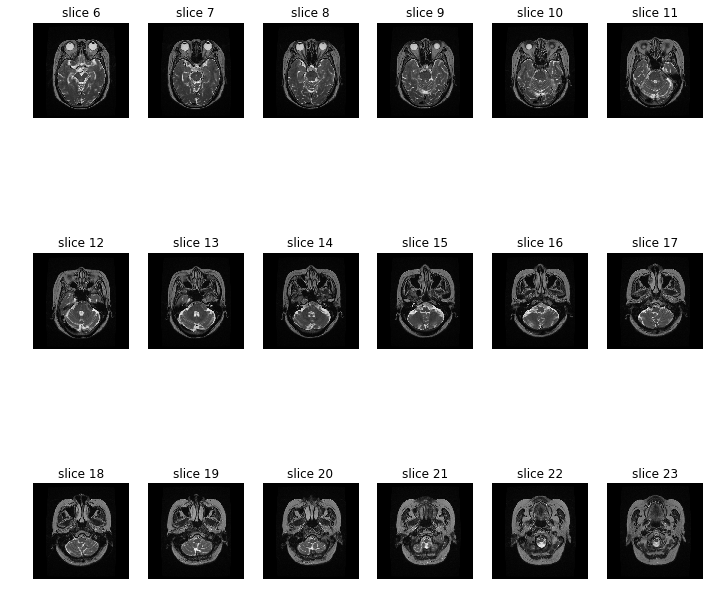

In [508]:
sample_stack(pixel, rows=6, cols=3, start_with=6, show_every=1)

In [556]:
combine=pixel[11][structurerange[0][0]:structurerange[1][0],structurerange[0][1]:structurerange[1][1]]

Populating the interactive namespace from numpy and matplotlib


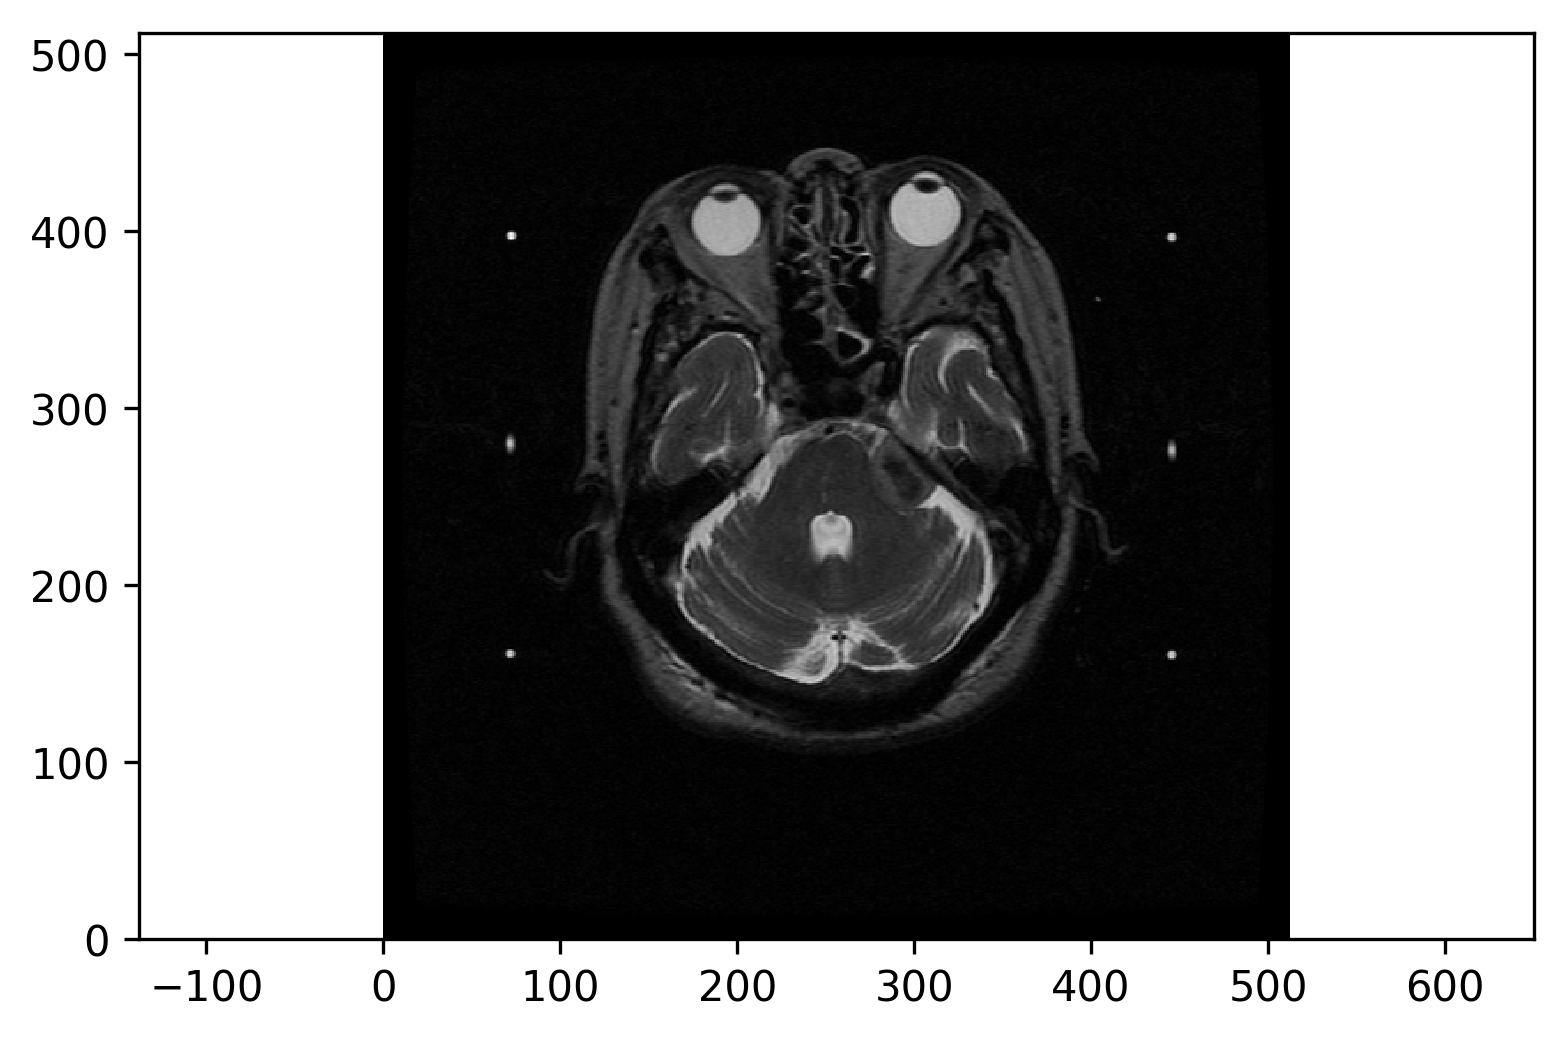

In [592]:
%pylab inline
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
#pyplot.set_cmap(pyplot.gray())
#pyplot.pcolormesh(x, y, np.flipud(structurepixeldata[-6.0]))
#pyplot.pcolormesh(y,x[-1::-1],np.flipud(pixel[13,:,10:400]))
#pyplot.pcolormesh(x[structurerange[0][0]:structurerange[1][0]+1],y[structurerange[0][1]:structurerange[1][1]+1],np.flipud(combine))
pyplot.pcolormesh(np.flipud(image['pixel'][11]))

Populating the interactive namespace from numpy and matplotlib


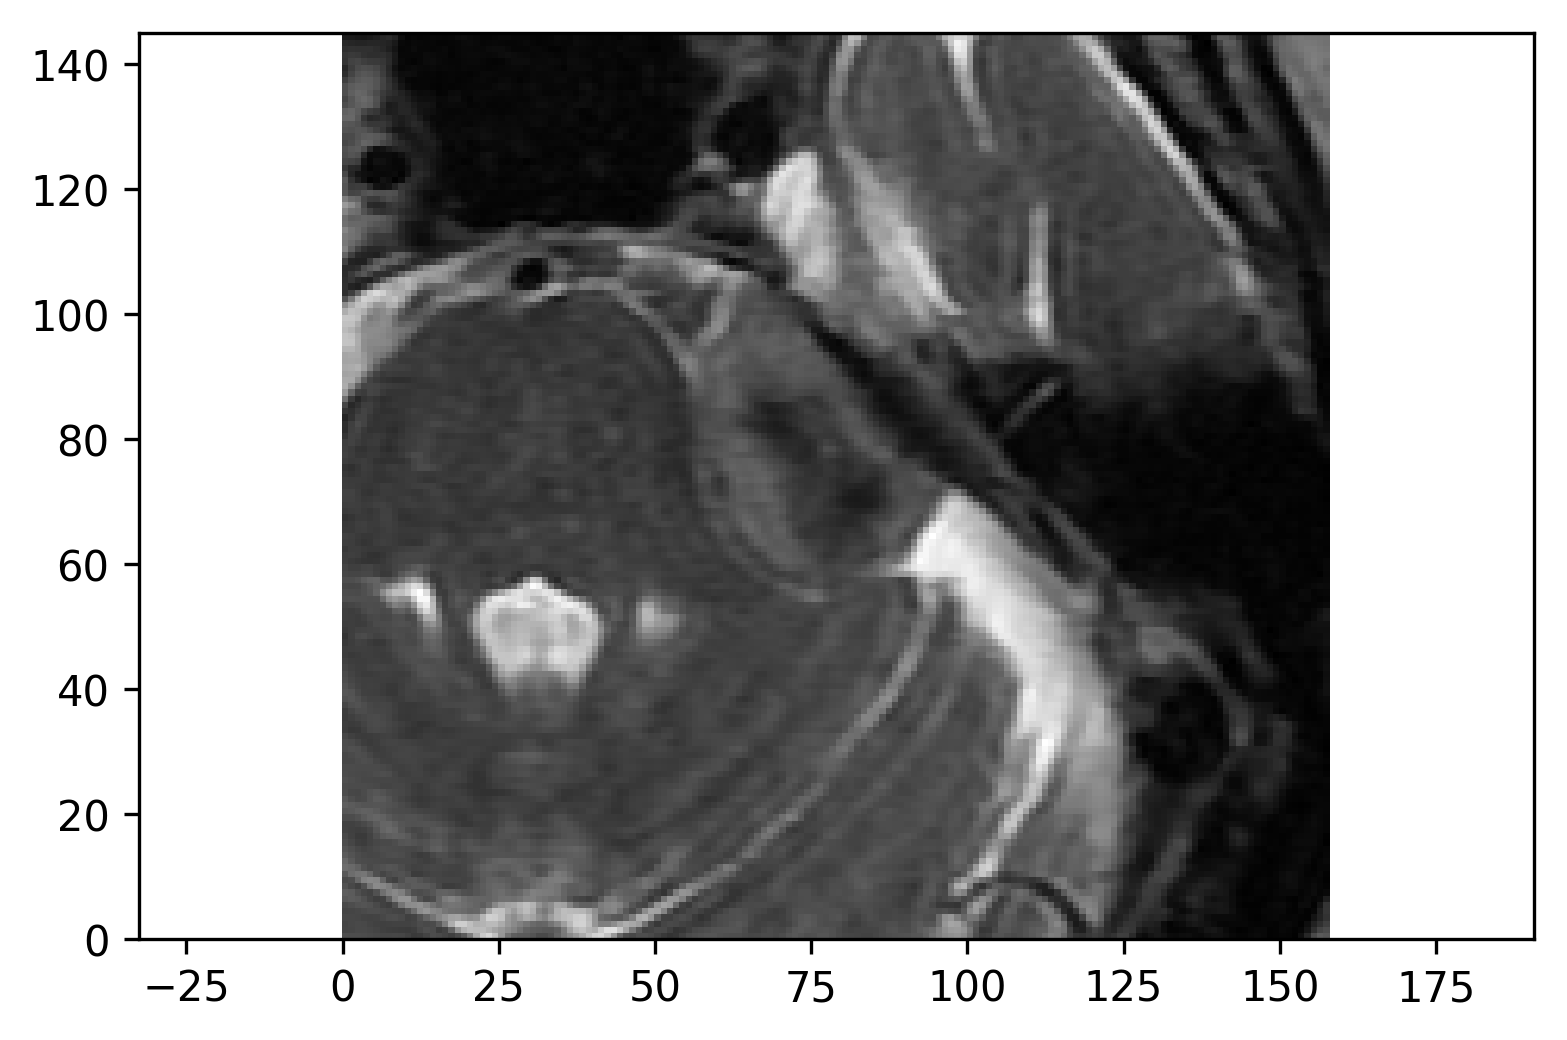

In [558]:

x=aim['pixellut'][0]
y=aim['pixellut'][1]
%pylab inline
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
#pyplot.set_cmap(pyplot.gray())
#pyplot.pcolormesh(x, y, np.flipud(structurepixeldata[-6.0]))
#pyplot.pcolormesh(y,x[-1::-1],np.flipud(pixel[13,:,10:400]))
#pyplot.pcolormesh(x[structurerange[0][0]:structurerange[1][0]+1],y[structurerange[0][1]:structurerange[1][1]+1],np.flipud(combine))
pyplot.pcolormesh(np.flipud(combine))




In [92]:
min(aim['pixellut'][0])

-112.635

In [282]:
patientinfo

{'72228517a51d29e48c0846abf08d292c67f4183f20140804': {'demographics': {'birth_date': '19340515',
   'family_name': 'HSU A AI',
   'gender': 'F',
   'given_name': '',
   'id': '1218407-5',
   'middle_name': '',
   'name': 'HSU A AI'},
  'series': {'1.2.840.113619.2.244.4120.7572023.12591.1407108057.885': {'description': 'AxI FSE T2',
    'id': '1.2.840.113619.2.244.4120.7572023.12591.1407108057.885',
    'modality': 'MR Image Storage',
    'numimages': 23,
    'referenceframe': '1.2.840.113619.2.244.4120.7572023.12591.1407108057.882',
    'study': '1.2.840.113820.5000.1.20140803121023.12121716121612'}},
  'studies': {'1.2.840.113820.5000.1.20140803121023.12121716121612': {'date': '20140804',
    'description': 'GK image special process',
    'id': '1.2.840.113820.5000.1.20140803121023.12121716121612'}}}}

In [162]:
aim['imagelocation'].index(-2.360232927800002)

2

In [163]:
len(aim['imagelocation'])

23

In [171]:
combine=dicommethodcore.catchstructure(aim,strmod)

TV


In [230]:
np.argmin(np.abs(np.array(float(0.00)) - (list(map(float, image['imagelocation'])))))

11

In [258]:
[aim['imagelocation'],image['imagelocation']]

[[60.63968679780001,
  57.639776293400004,
  54.63969736199999,
  51.63968828620001,
  48.63977778179999,
  45.639768705999984,
  42.6396897746,
  39.639779270199995,
  36.6397701944,
  33.639691263,
  30.639682187200002,
  27.6397716828,
  24.639762606999994,
  21.6396836756,
  18.639773171199998,
  15.6397640954,
  12.639853590999998,
  9.639676088200002,
  6.639765583800003,
  3.6398550794,
  0.6396775765999969,
  -2.360232927800002,
  -5.360242003599996,
  -8.360152507999995,
  -11.360330010799998,
  -14.3602405152,
  -17.360151019599996,
  -20.360318665259996,
  -23.36026859822,
  -26.36022838832,
  -29.36017832128,
  -32.36029668124,
  -35.360246614199994,
  -38.3601571186,
  -41.3603346214,
  -44.36024512579999,
  -47.3602542016,
  -50.360164706,
  -53.360342208800006,
  -56.3602527132,
  -59.3601632176,
  -62.3601722934,
  -65.3602512248,
  -68.3602603006,
  -71.360170805,
  -74.3602497364,
  -77.3602588122,
  -80.3601693166],
 [33.0,
  30.0,
  27.0,
  24.0,
  21.0,
  18.0,
  1

In [55]:
list(enumerate(image))

[(0, 'pixel'),
 (1, 'corridinate'),
 (2, 'imagelocation'),
 (3, 'patientposition'),
 (4, 'pixellut')]

In [87]:
strmod['datarange']=[(14.92240243, -21.2187475), (34.6138987, 4.08984674)]

In [53]:
[list(enumerate(aim)),list(enumerate(structure[0][1]))]

[[(0, 'pixel'),
  (1, 'corridinate'),
  (2, 'imagelocation'),
  (3, 'patientposition'),
  (4, 'pixellut')],
 [(0, 'id'),
  (1, 'name'),
  (2, 'color'),
  (3, 'empty'),
  (4, 'datarange'),
  (5, 'planes'),
  (6, 'thickness'),
  (7, 'zarray'),
  (8, 'zkeys'),
  (9, 'planepoint'),
  (10, 'planepixel'),
  (11, 'structurepixelshpae'),
  (12, 'structurerange')]]

In [ ]:
time.time()

In [9]:
import time
t0=time.time()
patientinfo, h_record,image,structure,plan,rtdose = dicom_read.load_scan(PathDicom)
t1=time.time()
t1-t0

Found ROI #%s: %s 1 TV
Found ROI #%s: %s 2 *Skull
TV


1.6730360984802246

In [10]:
image=image['72228517a51d29e48c0846abf08d292c67f4183f20140804']['1.2.840.113619.2.244.4120.7572023.12591.1407108057.885']

In [11]:
structure=structure['72228517a51d29e48c0846abf08d292c67f4183f20140804']['1.2.840.113619.2.244.4120.7572023.12591.1407108057.885']

In [ ]:
pixlut=image['pixellut']

In [ ]:
for i,j in enumerate(image):
    print(j)

In [ ]:
position=image['imagelocation']

In [ ]:
for i,j in enumerate(structure[0][1]):
    print(j)

In [ ]:
if not "zarray" in structure[0][1]:
    structure[0][1]['zarray'] = np.array(list(structure[0][1]['planes'].keys()), dtype=np.float32)
    structure[0][1]['zkeys'] = structure[0][1]['planes'].keys()

In [ ]:
np.argmin(np.abs(structure[0][1]['zarray'][20] - list(map(float, position))))

In [ ]:
structure[0][1]['zarray'] = np.array(list(structure[0][1]['planes'].keys()), dtype=np.float32)
structure[0][1]['zkeys'] = structure[0][1]['planes'].keys()

In [ ]:
for i,j in enumerate(structurepixel):
    print(j)

In [ ]:
structure[0][1]['zarray'] = np.array(list(structure[0][1]['planes'].keys()), dtype=np.float32)
structure[0][1]['zkeys'] = structure[0][1]['planes'].keys()

In [ ]:
for i,j in enumerate(image):
    print(j)

In [ ]:
structure[0][1]['structurepixelshpae'][0,:,:]

In [ ]:
test=np.array([-1] *4 ,dtype=int16 )
j=0

In [ ]:
test=[]
j=0

In [ ]:
structure[0][1]['structurerange']

In [13]:
x=image['pixellut'][0]
y=image['pixellut'][1]

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot', 'Annotation', 'Polygon', 'Figure', 'random', '__version__', 'linalg', 'resize']
`%matplotlib` prevents importing * from pylab and numpy



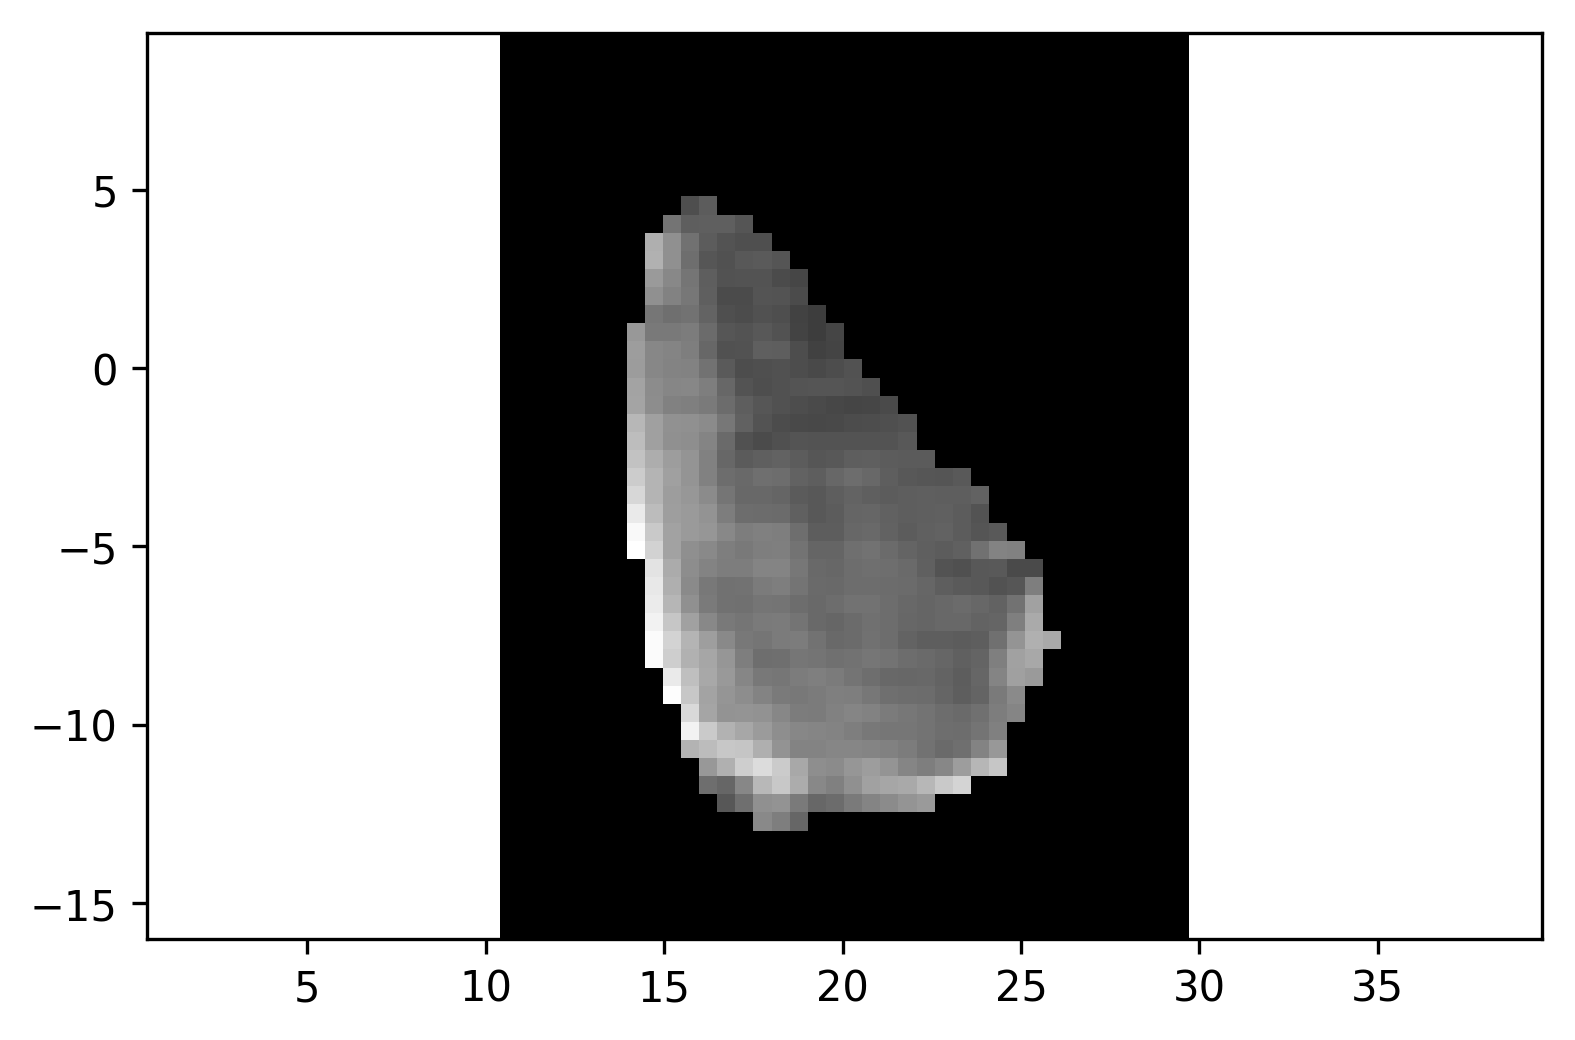

In [17]:
structurerange=structure[0][1]['structurerange']
x=image['pixellut'][0]
y=image['pixellut'][1]
%pylab inline
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
#pyplot.pcolormesh(x, y, np.flipud(structurepixeldata[-6.0]))
#pyplot.pcolormesh(y,x[-1::-1],np.flipud(pixel[13,:,10:400]))
pyplot.pcolormesh(x[structurerange[0][0]:structurerange[1][0]+1],y[structurerange[0][1]:structurerange[1][1]+1],np.flipud(structure[0][1]['structurepixelshpae'][0]))




[]

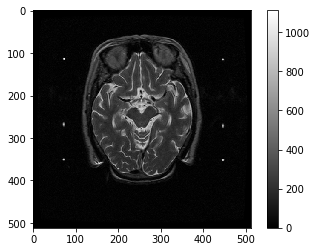

In [18]:
pyplot.imshow(image['pixel'][5,:,:])
pyplot.colorbar()
pyplot.plot()

In [ ]:
%pylab inline
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
#pyplot.pcolormesh(x, y, np.flipud(structurepixeldata[-6.0]))
#pyplot.pcolormesh(y,x[-1::-1],np.flipud(pixel[13,:,10:400]))
pyplot.pcolormesh(x[281:306],y[233:266],np.flipud(pixel[13,233:266,281:306]))




In [ ]:
%pylab inline


pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
#pyplot.pcolormesh(x, y, np.flipud(structurepixeldata[-6.0]))
#pyplot.pcolormesh(x[281:306],y[233:266],np.flipud(structurepixeldata[-6.0]))
pyplot.pcolormesh(x[281:306],y[233:266],np.flipud((structurepixelshpae[-6.0][:,:])))





In [ ]:
%pylab inline


pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
#pyplot.pcolormesh(x, y, np.flipud(structurepixeldata[-6.0]))
#pyplot.pcolormesh(x[281:306],y[233:266],np.flipud(structurepixeldata[-6.0]))
pyplot.pcolormesh(np.flipud((structurepixelshpae[-0.0][:,:])))



In [ ]:
image=image['72228517a51d29e48c0846abf08d292c67f4183f20140804']['1.2.840.113619.2.244.4120.7572023.12591.1407108057.885']

pixelut y座標要反轉


In [ ]:
%pylab inline
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(im['5d19d3db6d86b1b816c9af8906f2ae4d3b293a8a']['corridinate'][0], im['5d19d3db6d86b1b816c9af8906f2ae4d3b293a8a']['corridinate'][1], np.flipud(im['5d19d3db6d86b1b816c9af8906f2ae4d3b293a8a']['pixel'][20,:, :]))

In [ ]:
files =[(PathDicom + '/' + s) for s in os.listdir(PathDicom)]

In [ ]:
patient, rtdose, rtplan, rtss=load_scan =load_scan(PathDicom)
#imgs, x, y, z = get_img_pixels_hu(patient)
#read dicom 

In [ ]:
imgs, x, y, z = get_img_pixels_hu(patientall['images'])

In [ ]:
d = np.frombuffer(rtdose[0].PixelData,dtype=np.int16)
d = d.reshape((rtdose[0].NumberOfFrames,rtdose[0].Columns,rtdose[0].Rows))

d.shape

In [ ]:
from enthought.mayavi import mlab
mlab.pipeline.scalar_field(d)

#save and load

In [ ]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

In [ ]:
#load one
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

In [ ]:
#read stack
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

save.plot

In [ ]:
pyplot.hist(image['pixel'].flatten(), bins=50, color='c')
pyplot.xlabel("Hounsfield Units (HU)")
pyplot.ylabel("Frequency")
pyplot.show()

In [ ]:
pyplot.imshow(image['pixel'][5,:,:])
pyplot.colorbar()
pyplot.plot()

In [ ]:
imgs.shape

In [ ]:
%pylab inline
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(imgs[20,:, :]))

In [19]:
#Displaying an Image Stack¶
#show_every: every show jump
#start_with start index
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=1):
    if rows>cols:
        tmp = rows
        rows =cols
        cols = tmp        
    fig,ax = pyplot.subplots(rows,cols,figsize=[12,12])
    indi=max(rows,cols)       
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/indi),int(i % indi)].set_title('slice %d' % ind)
        ax[int(i/indi),int(i % indi)].imshow(stack[ind],cmap='gray')
        ax[int(i/indi),int(i % indi)].axis('off')
    pyplot.show()

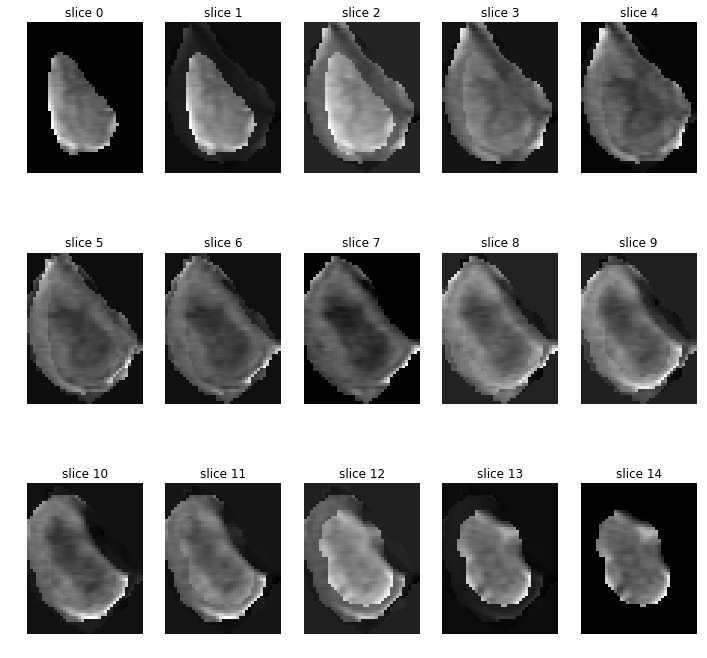

In [23]:
imgs_after_resamp=scipy.ndimage.interpolation.zoom(structure[0][1]['structurepixelshpae'], [3,1,1])
sample_stack(imgs_after_resamp, rows=3, cols=5, start_with=0, show_every=1)

In [27]:
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=cube.shape[0]*2)
    ax.set_ylim(top=cube.shape[1]*2)
    ax.set_zlim(top=cube.shape[2]*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors)
    plt.show()

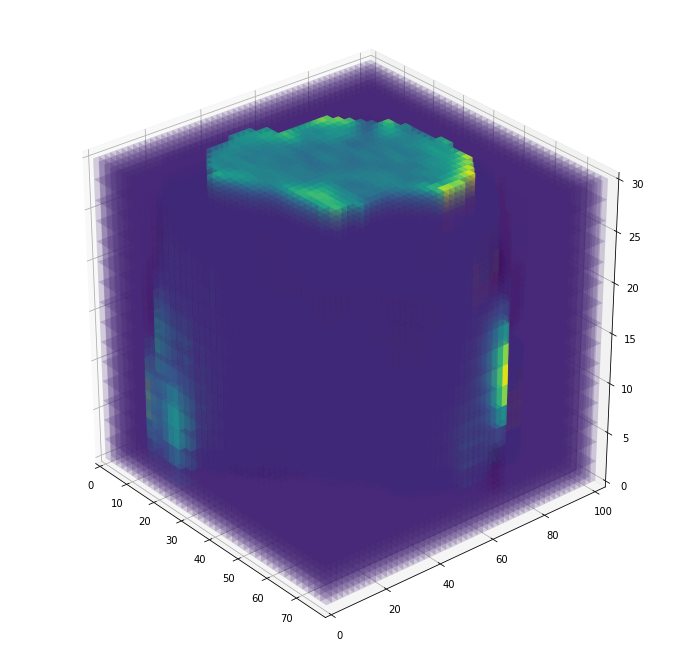

In [30]:
plot_cube(imgs_after_resamp.transpose(2,1,0)[:,:,:])

In [ ]:
structure[0][1]['structurepixelshpae'].shape[0]

In [ ]:
plot_cube(structure[0][1]['structurepixelshpae'].transpose(2,1,0)[:,:,:])

In [ ]:
plot_cube(structure[0][1]['structurepixelshpae'].transpose(2,1,0)[:,:,:],angle=90)

In [ ]:
cube=image['pixel'].transpose(2,1,0)
IMG_DIM=10
for x in range(0, IMG_DIM):
    for y in range(0, IMG_DIM):
        for z in range(max(x-y+5, 0), IMG_DIM):
            cube[x, y, z] = 0
plot_cube(cube, angle=200)

resample

In [21]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([patient[0].SliceThickness]+[patient[0].PixelSpacing[0]]+[patient[0].PixelSpacing[1]]))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [ ]:
imgs_after_resamp, spacing=resample(imgs,patient,[1,1,1])

Segmentation

In [ ]:
#Standardize the pixel values
def make_mask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the brain
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [ ]:
img = imgs_after_resamp[6]
#img=image['pixel'][13]
make_mask(img, display=True)

Apply Masks to All Slices¶
The single-slice example seemed to work pretty well.
Let's now apply the mask to all the slices in this CT and show a few examples.


In [ ]:
masked_brain = []
for img in imgs_after_resamp:
    masked_brain.append(make_mask(img))
sample_stack(masked_brain, show_every=1)

3D Plotting

In [22]:
imgs_after_resamp=scipy.ndimage.interpolation.zoom(structure[0][1]['structurepixelshpae'], [3,1,1])

In [ ]:
imgs_after_resamp.shape

In [ ]:
v, f =make_mesh(image['pixel'],350)
plt_3d(v, f)

In [ ]:
#v, f =make_mesh(structure[0][1]['structurepixelshpae'],300)
v, f =make_mesh(imgs_after_resamp,300)
plt_3d(v, f)

In [ ]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

In [ ]:
def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

In [ ]:
def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()


In [ ]:
v, f = make_mesh(d, 150)
plt_3d(v, f)

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350)

In [ ]:
plt_3d(v, f)

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v, f)

test

In [ ]:
doesRefDs=pydicom.read_file(rtdoes_filenameDCM[0])
RefDs.squeeze(3)

In [ ]:
#rtdoes
# Get ref file
doesRefDs=pydicom.read_file(rtdoes_filenameDCM[0])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(doesRefDs.Rows), int(doesRefDs.Columns), len(rtdoes_filenameDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(doesRefDs.PixelSpacing[0]), float(doesRefDs.PixelSpacing[1]), float(doesRefDs.SliceThickness))

x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
 #The array is sized based on 'ConstPixelDims'
IMGArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in rtdoes_filenameDCM:
     # read the file
    doesds = pydicom.read_file(filenameDCM)
    # store the raw image data
    DOESArrayDicom[:, :, rtdoes_filenameDCM.index(filenameDCM)] = doesds.pixel_array  




In [ ]:
rtss_filename

In [ ]:
rtplan_filename

In [ ]:
doesRefDs.SliceThickness

In [ ]:
doesRefDs.trait_names()
#see name

In [ ]:
doesRefDs

plot

In [ ]:
def multiple(self,function):
    data=[]
    if len(self)>0:
        for s in range(0,len(data)):
            temp=self[s]
            data+=[function(temp)]
        return data

In [ ]:
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(imgx, imgy, np.flipud(IMGArrayDicom[:, :, 11]))

In [ ]:
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(imgz, imgx, np.flipud(IMGArrayDicom[:, 15, :]))

In [ ]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
ax.plot_wireframe(imgx, imgy, , rstride=5, cstride=5)

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    pyplot.draw()
    pyplot.pause(.001)

In [ ]:
lstFilesDCM

In [ ]:
img_filenameDCM.sort(key = lambda x: int(x.InstanceNumber))

In [ ]:
rtplan_filename

In [ ]:
imgRefDs=pydicom.read_file(img_filenameDCM[0])

In [ ]:
imgRefDs

import f

In [ ]:
def GetPatientToPixelLUT(image):
    """Get the image transformation matrix from the DICOM standard Part 3
        Section C.7.6.2.1.1"""
    image_x=[]
    image_y=[]
    self=image
    di = self.PixelSpacing[0]
    dj = self.PixelSpacing[1]
    orientation = self.ImageOrientationPatient
    position = self.ImagePositionPatient

    m = np.matrix(
            [[orientation[0]*di, orientation[3]*dj, 0, position[0]],
            [orientation[1]*di, orientation[4]*dj, 0, position[1]],
            [orientation[2]*di, orientation[5]*dj, 0, position[2]],
            [0, 0, 0, 1]])

    x = []
    y = []
    for i in range(0, self.Columns):
        imat = m * np.matrix([[i], [0], [0], [1]])
        x.append(float(imat[0]))
    for j in range(0, self.Rows):
        jmat = m * np.matrix([[0], [j], [0], [1]])
        y.append(float(jmat[1]))
    image_x=np.array(x)
    image_y=np.array(y)

    return (image_x, image_y)

In [ ]:
def MultiGetPatientToPixelLUT(image):
    """Get the image transformation matrix from the DICOM standard Part 3
        Section C.7.6.2.1.1"""
    image_x=[]
    image_y=[]
    for s in range(0,len(image)):
        self=image[s]
        di = self.PixelSpacing[0]
        dj = self.PixelSpacing[1]
        orientation = self.ImageOrientationPatient
        position = self.ImagePositionPatient

        m = np.matrix(
            [[orientation[0]*di, orientation[3]*dj, 0, position[0]],
            [orientation[1]*di, orientation[4]*dj, 0, position[1]],
            [orientation[2]*di, orientation[5]*dj, 0, position[2]],
            [0, 0, 0, 1]])

        x = []
        y = []
        for i in range(0, self.Columns):
            imat = m * np.matrix([[i], [0], [0], [1]])
            x.append(float(imat[0]))
        for j in range(0, self.Rows):
            jmat = m * np.matrix([[0], [j], [0], [1]])
            y.append(float(jmat[1]))
        image_x+=[np.array(x)]
        image_y+=[np.array(y)]

    return (image_x, image_y)

In [ ]:
def GetDoseGridPixelData(self, pixlut, doselut):
    """Convert dosegrid data into pixel data using the dose to pixel LUT."""
    dosedata = []
    x = []
    y = []
    # Determine if the patient is prone or supine
    imdata = self[(len(self)-1)]
    prone = -1 if 'p' in imdata.PatientPosition.lower() else 1
    feetfirst = -1 if 'ff' in imdata.PatientPosition.lower() else 1
    # Get the pixel spacing
    spacing = imdata.PixelSpacing if hasattr(imdata,'PixelSpacing') else [1,1]

        # Transpose the dose grid LUT onto the image grid LUT
    x = (np.array(doselut[0]) - pixlut[0][0]) * prone * feetfirst / spacing[0]
    y = (np.array(doselut[1]) - pixlut[1][0]) * prone / spacing[1]
    return (x, y)

In [ ]:
def GetDoseGridPixelData3dim2ddo(self, pixlut, doselut):
    #
    """Convert dosegrid data into pixel data using the dose to pixel LUT."""
    dosedata = []
    x = []
    y = []
    # Determine if the patient is prone or supine
    imdata = self[(len(self)-1)]
    prone = -1 if 'p' in imdata.PatientPosition.lower() else 1
    feetfirst = -1 if 'ff' in imdata.PatientPosition.lower() else 1
    # Get the pixel spacing
    spacing = imdata.PixelSpacing if hasattr(imdata,'PixelSpacing') else [1,1]

        # Transpose the dose grid LUT onto the image grid LUT
    x = (np.array(doselut[0]) - pixlut[0][0]) * prone * feetfirst / spacing[0]
    y = (np.array(doselut[1]) - pixlut[1][0]) * prone / spacing[1]
    return (x, y)